In [1]:
import scipy.io
import urllib.request
import dgl
import math
import numpy as np
import time
import copy

from torch import Tensor
from HGTDGL.model import *
from mlp import *
from utils import *
from solutionC import *
from solutionD import *

Using backend: pytorch


In [3]:
import gc
# free up CUDA memory
gc.collect()
torch.cuda.empty_cache()

# MLP Experiment Model

In [5]:
def SolCMLP(subject, sample_subjects):
    data_url = 'https://data.dgl.ai/dataset/ACM.mat'
    data_file_path = './HGTDGL/tmp/ACM.mat'

    urllib.request.urlretrieve(data_url, data_file_path)
    data = scipy.io.loadmat(data_file_path)

    device = torch.device("cuda:0")

    # get index of subject
    subjectCodes = []
    for s in data['L']:
        subjectCodes.append(s[0][0])
    assert subject in subjectCodes, "not a vaid subject"
    subject_index = subjectCodes.index(subject)


    G = dgl.heterograph({
            ('paper', 'written-by', 'author') : data['PvsA'].nonzero(),
            ('author', 'writing', 'paper') : data['PvsA'].transpose().nonzero(),
            ('paper', 'citing', 'paper') : data['PvsP'].nonzero(),
            ('paper', 'cited', 'paper') : data['PvsP'].transpose().nonzero(),
            ('paper', 'is-about', 'subject') : data['PvsL'].nonzero(),
            ('subject', 'has', 'paper') : data['PvsL'].transpose().nonzero(),
            ('paper', 'published-by', 'conference') : data['PvsC'].nonzero(),
            ('conference', 'published', 'paper') : data['PvsC'].transpose().nonzero(),
        }).to(device)

    # remove edges from paper-conference
    sample_papers = torch.tensor([]).to(device)
    for s in sample_subjects:
        index = subjectCodes.index(s)
        sample_papers = torch.concat([sample_papers, (G.successors(index, etype='has'))])
    sample_papers = torch.unique(sample_papers)

    PvsC_edges = G.edges(etype='published-by')
    CvsP_edges = G.edges(etype='published')
    edges1 = []
    edges2 = []
    for i in range(PvsC_edges[0].size()[0]):
        if PvsC_edges[0][i] in sample_papers:
            edges1.append(i)
        if CvsP_edges[1][i] in sample_papers:
            edges2.append(i)
    G.remove_edges(torch.tensor(edges1).to(device), 'published-by')
    G.remove_edges(torch.tensor(edges2).to(device), 'published')


    # papers about the subject
    subject_papers = torch.tensor([]).to(device)
    subject_papers = subject_papers.type(torch.int64)
    subject_papers = torch.concat([subject_papers, (G.successors(subject_index, etype='has'))])
    subject_papers = torch.unique(subject_papers)

    # papers cited in subject papers
    cited_papers = torch.tensor([]).to(device)
    cited_papers = cited_papers.type(torch.int64)
    for p in subject_papers:
        cited_papers = torch.concat([cited_papers, (G.successors(p, etype='citing'))])
    cited_papers = torch.unique(cited_papers)
    papers = torch.unique(torch.concat([cited_papers, subject_papers]))

    # authors that wrote the subject papers (not cited papers)
    authors = torch.tensor([]).to(device)
    authors = authors.type(torch.int64)
    for p in subject_papers:
        authors = torch.concat([authors, (G.successors(p, etype='written-by'))])
    authors = torch.unique(authors)

    conferences = G.nodes('conference')

    # gets subgraph with edges connecting the subject, subject papers, cited papers, and authors
    subgraph = dgl.node_subgraph(G, {'subject':subject_index,'author':authors, 'paper':papers, 'conference': conferences}).to(device)

    subgraph.add_nodes(G.num_nodes('author')- subgraph.num_nodes('author'), ntype='author')
    subgraph.add_nodes(G.num_nodes('paper') - subgraph.num_nodes('paper'), ntype='paper')
    subgraph.add_nodes(G.num_nodes('subject') - subgraph.num_nodes('subject'), ntype='subject')


    pvc = data['PvsC'].tocsr()
    p_selected = pvc.tocoo()
    # generate labels
    labels = pvc.indices
    labels = torch.tensor(labels).long()

    triple_labels = Triples(labels, subject_papers)

    # generate train/val/test split using only subject papers 70/15/15 split
    #pid = subject_papers.tolist()
    n = triple_labels.size()[0]
    shuffle = np.random.permutation(list(range(n)))
    train_idx = torch.tensor(shuffle[0:int(0.75*n)]).long()
    val_idx = torch.tensor(shuffle[int(0.75*n):int(0.90*n)]).long()
    test_idx = torch.tensor(shuffle[int(0.90*n):]).long()

    subgraph.node_dict = {}
    subgraph.edge_dict = {}
    for ntype in subgraph.ntypes:
        subgraph.node_dict[ntype] = len(subgraph.node_dict)
    for etype in subgraph.etypes:
        subgraph.edge_dict[etype] = len(subgraph.edge_dict)
        subgraph.edges[etype].data['id'] = torch.ones(subgraph.number_of_edges(etype), dtype=torch.long).to(device) * subgraph.edge_dict[etype]
        
    #     Random initialize input feature
    for ntype in subgraph.ntypes:
        emb = nn.Parameter(torch.Tensor(subgraph.number_of_nodes(ntype), 400), requires_grad = False).to(device)
        nn.init.xavier_uniform_(emb)
        subgraph.nodes[ntype].data['inp'] = emb
        

    model_hgt = HGT(subgraph, n_inp=400, n_hid=200, n_out=64, n_layers=2, n_heads=4, use_norm = True).to(device)
    #model_conference = HGT(subgraph, n_inp=400, n_hid=200, n_out=64, n_layers=2, n_heads=4, use_norm = True).to(device)
    optimizer_hgt = torch.optim.AdamW(model_hgt.parameters())
    scheduler_hgt = torch.optim.lr_scheduler.OneCycleLR(optimizer_hgt, total_steps=100, max_lr = 1e-3, pct_start=0.05)
    #optimizer_conference = torch.optim.AdamW(model_conference.parameters())
    #scheduler_conference = torch.optim.lr_scheduler.OneCycleLR(optimizer_conference, total_steps=100, max_lr = 1e-3, pct_start=0.05)

    model_mlp = Feedforward(128, 256).to(device)
    optimizer_mlp = torch.optim.AdamW(model_mlp.parameters())
    scheduler_mlp = torch.optim.lr_scheduler.OneCycleLR(optimizer_mlp, total_steps=100, max_lr = 1e-3, pct_start=0.05)

    best_val_acc = 0
    best_test_acc = 0
    train_step = 0

    start = time.time()
    best_model_hgt = copy.deepcopy(model_hgt)
    #best_model_conference = copy.deepcopy(model_conference)
    best_model_mlp = copy.deepcopy(model_mlp)

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    time_list = []

    best_val_acc = torch.tensor([0]).float()
    best_test_acc = torch.tensor([0]).float()

    for epoch in range(100):
        logits_paper = model_hgt(subgraph, 'paper')
        logits_conference = model_hgt(subgraph, 'conference')
        # The loss is computed only for labeled nodes.
        # pred = torch.tensor([]).to(device)
        # for i in range(triple_labels.size()[0]):
        #     paper_emb = logits_paper[triple_labels[i,0]]
        #     conference_emb = logits_conference[triple_labels[i,1]]
        #     pred = torch.cat([pred, model_mlp(torch.cat([paper_emb, conference_emb]))])

        paper_emb = logits_paper[triple_labels[:,0]]
        conference_emb = logits_conference[triple_labels[:,1]]
        pred = model_mlp(torch.cat([paper_emb, conference_emb], dim=1)).squeeze()

        #pred = m(pred)
        loss = F.binary_cross_entropy(pred[train_idx], triple_labels[train_idx,2].float().to(device))

        pred = pred.cpu()
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = (pred[train_idx] == triple_labels[train_idx,2]).float().mean()
        val_acc   = (pred[val_idx] == triple_labels[val_idx,2]).float().mean()
        test_acc  = (pred[test_idx] == triple_labels[test_idx,2]).float().mean()
        current_time = time.time()

        train_acc_list.append(train_acc.item())
        val_acc_list.append(val_acc.item())
        test_acc_list.append(test_acc.item())
        time_list.append(current_time-start)

        optimizer_hgt.zero_grad()
        #optimizer_conference.zero_grad()
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_hgt.step()
        #optimizer_conference.step()
        optimizer_mlp.step()
        train_step += 1
        scheduler_hgt.step(train_step)
        #scheduler_conference.step(train_step)
        scheduler_mlp.step(train_step)

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_model_hgt = copy.deepcopy(model_hgt)
            #best_model_conference = copy.deepcopy(model_conference)
            best_model_mlp = copy.deepcopy(model_mlp)

        if epoch % 10 == 0:
            print('LR: %.5f Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
            optimizer_hgt.param_groups[0]['lr'], 
            loss.item(),
            train_acc.item(),
            val_acc.item(),
            best_val_acc.item(),
            test_acc.item(),
            best_test_acc.item(),
        ))

    results = {}
    results['best_model_hgt'] = best_model_hgt
    #results['best_model_conference'] = best_model_conference
    results['best_model_mlp'] = best_model_mlp
    results['last_model_hgt'] = model_hgt
    #results['last_model_conference'] = model_conference
    results['last_model_mlp'] = model_mlp
    results['time_list'] = time_list
    results['train_acc_list'] = train_acc_list
    results['val_acc_list'] = val_acc_list
    results['test_acc_list'] = test_acc_list
    return results

In [6]:
def FineTuneMLP(subject, sample_subjects, trained_hgt, trained_mlp):
    data_url = 'https://data.dgl.ai/dataset/ACM.mat'
    data_file_path = './HGTDGL/tmp/ACM.mat'

    urllib.request.urlretrieve(data_url, data_file_path)
    data = scipy.io.loadmat(data_file_path)

    device = torch.device("cuda:0")

    # get index of subject
    subjectCodes = []
    for s in data['L']:
        subjectCodes.append(s[0][0])
    assert subject in subjectCodes, "not a vaid subject"
    subject_index = subjectCodes.index(subject)


    G = dgl.heterograph({
            ('paper', 'written-by', 'author') : data['PvsA'].nonzero(),
            ('author', 'writing', 'paper') : data['PvsA'].transpose().nonzero(),
            ('paper', 'citing', 'paper') : data['PvsP'].nonzero(),
            ('paper', 'cited', 'paper') : data['PvsP'].transpose().nonzero(),
            ('paper', 'is-about', 'subject') : data['PvsL'].nonzero(),
            ('subject', 'has', 'paper') : data['PvsL'].transpose().nonzero(),
            ('paper', 'published-by', 'conference') : data['PvsC'].nonzero(),
            ('conference', 'published', 'paper') : data['PvsC'].transpose().nonzero(),
        }).to(device)

    # remove edges from paper-conference
    sample_papers = torch.tensor([]).to(device)
    for s in sample_subjects:
        index = subjectCodes.index(s)
        sample_papers = torch.concat([sample_papers, (G.successors(index, etype='has'))])
    sample_papers = torch.unique(sample_papers)

    PvsC_edges = G.edges(etype='published-by')
    CvsP_edges = G.edges(etype='published')
    edges1 = []
    edges2 = []
    for i in range(PvsC_edges[0].size()[0]):
        if PvsC_edges[0][i] in sample_papers:
            edges1.append(i)
        if CvsP_edges[1][i] in sample_papers:
            edges2.append(i)
    G.remove_edges(torch.tensor(edges1).to(device), 'published-by')
    G.remove_edges(torch.tensor(edges2).to(device), 'published')


    # papers about the subject
    subject_papers = torch.tensor([]).to(device)
    subject_papers = subject_papers.type(torch.int64)
    subject_papers = torch.concat([subject_papers, (G.successors(subject_index, etype='has'))])
    subject_papers = torch.unique(subject_papers)

    # papers cited in subject papers
    cited_papers = torch.tensor([]).to(device)
    cited_papers = cited_papers.type(torch.int64)
    for p in subject_papers:
        cited_papers = torch.concat([cited_papers, (G.successors(p, etype='citing'))])
    cited_papers = torch.unique(cited_papers)
    papers = torch.unique(torch.concat([cited_papers, subject_papers]))

    # authors that wrote the subject papers (not cited papers)
    authors = torch.tensor([]).to(device)
    authors = authors.type(torch.int64)
    for p in subject_papers:
        authors = torch.concat([authors, (G.successors(p, etype='written-by'))])
    authors = torch.unique(authors)

    conferences = G.nodes('conference')

    # gets subgraph with edges connecting the subject, subject papers, cited papers, and authors
    subgraph = dgl.node_subgraph(G, {'subject':subject_index,'author':authors, 'paper':papers, 'conference': conferences}).to(device)

    subgraph.add_nodes(G.num_nodes('author')- subgraph.num_nodes('author'), ntype='author')
    subgraph.add_nodes(G.num_nodes('paper') - subgraph.num_nodes('paper'), ntype='paper')
    subgraph.add_nodes(G.num_nodes('subject') - subgraph.num_nodes('subject'), ntype='subject')


    pvc = data['PvsC'].tocsr()
    p_selected = pvc.tocoo()
    # generate labels
    labels = pvc.indices
    labels = torch.tensor(labels).long()

    triple_labels = Triples(labels, subject_papers)

    # generate train/val/test split using only subject papers 70/15/15 split
    #pid = subject_papers.tolist()
    n = triple_labels.size()[0]
    shuffle = np.random.permutation(list(range(n)))
    train_idx = torch.tensor(shuffle[0:int(0.75*n)]).long()
    val_idx = torch.tensor(shuffle[int(0.75*n):int(0.90*n)]).long()
    test_idx = torch.tensor(shuffle[int(0.90*n):]).long()

    subgraph.node_dict = {}
    subgraph.edge_dict = {}
    for ntype in subgraph.ntypes:
        subgraph.node_dict[ntype] = len(subgraph.node_dict)
    for etype in subgraph.etypes:
        subgraph.edge_dict[etype] = len(subgraph.edge_dict)
        subgraph.edges[etype].data['id'] = torch.ones(subgraph.number_of_edges(etype), dtype=torch.long).to(device) * subgraph.edge_dict[etype]
        
    #     Random initialize input feature
    for ntype in subgraph.ntypes:
        emb = nn.Parameter(torch.Tensor(subgraph.number_of_nodes(ntype), 400), requires_grad = False).to(device)
        nn.init.xavier_uniform_(emb)
        subgraph.nodes[ntype].data['inp'] = emb
        

    model_hgt = trained_hgt
    model_mlp = trained_mlp

    #model_hgt = HGT(subgraph, n_inp=400, n_hid=200, n_out=64, n_layers=2, n_heads=4, use_norm = True).to(device)
    #model_conference = HGT(subgraph, n_inp=400, n_hid=200, n_out=64, n_layers=2, n_heads=4, use_norm = True).to(device)
    optimizer_hgt = torch.optim.AdamW(model_hgt.parameters())
    scheduler_hgt = torch.optim.lr_scheduler.OneCycleLR(optimizer_hgt, total_steps=100, max_lr = 1e-3, pct_start=0.05)
    #optimizer_conference = torch.optim.AdamW(model_conference.parameters())
    #scheduler_conference = torch.optim.lr_scheduler.OneCycleLR(optimizer_conference, total_steps=100, max_lr = 1e-3, pct_start=0.05)

    #model_mlp = Feedforward(128, 256).to(device)
    optimizer_mlp = torch.optim.AdamW(model_mlp.parameters())
    scheduler_mlp = torch.optim.lr_scheduler.OneCycleLR(optimizer_mlp, total_steps=100, max_lr = 1e-3, pct_start=0.05)

    best_val_acc = 0
    best_test_acc = 0
    train_step = 0

    start = time.time()
    best_model_hgt = copy.deepcopy(model_hgt)
    #best_model_conference = copy.deepcopy(model_conference)
    best_model_mlp = copy.deepcopy(model_mlp)

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    time_list = []

    best_val_acc = torch.tensor([0]).float()
    best_test_acc = torch.tensor([0]).float()

    for epoch in range(100):
        logits_paper = model_hgt(subgraph, 'paper')
        logits_conference = model_hgt(subgraph, 'conference')
        # The loss is computed only for labeled nodes.
        # pred = torch.tensor([]).to(device)
        # for i in range(triple_labels.size()[0]):
        #     paper_emb = logits_paper[triple_labels[i,0]]
        #     conference_emb = logits_conference[triple_labels[i,1]]
        #     pred = torch.cat([pred, model_mlp(torch.cat([paper_emb, conference_emb]))])

        paper_emb = logits_paper[triple_labels[:,0]]
        conference_emb = logits_conference[triple_labels[:,1]]
        pred = model_mlp(torch.cat([paper_emb, conference_emb], dim=1)).squeeze()

        #pred = m(pred)
        loss = F.binary_cross_entropy(pred[train_idx], triple_labels[train_idx,2].float().to(device))

        pred = pred.cpu()
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        train_acc = (pred[train_idx] == triple_labels[train_idx,2]).float().mean()
        val_acc   = (pred[val_idx] == triple_labels[val_idx,2]).float().mean()
        test_acc  = (pred[test_idx] == triple_labels[test_idx,2]).float().mean()
        current_time = time.time()

        train_acc_list.append(train_acc.item())
        val_acc_list.append(val_acc.item())
        test_acc_list.append(test_acc.item())
        time_list.append(current_time-start)

        optimizer_hgt.zero_grad()
        #optimizer_conference.zero_grad()
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_hgt.step()
        #optimizer_conference.step()
        optimizer_mlp.step()
        train_step += 1
        scheduler_hgt.step(train_step)
        #scheduler_conference.step(train_step)
        scheduler_mlp.step(train_step)

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_model_hgt = copy.deepcopy(model_hgt)
            #best_model_conference = copy.deepcopy(model_conference)
            best_model_mlp = copy.deepcopy(model_mlp)

        if epoch % 10 == 0:
            print('LR: %.5f Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
            optimizer_hgt.param_groups[0]['lr'], 
            loss.item(),
            train_acc.item(),
            val_acc.item(),
            best_val_acc.item(),
            test_acc.item(),
            best_test_acc.item(),
        ))

    results = {}
    results['best_model_hgt'] = best_model_hgt
    #results['best_model_conference'] = best_model_conference
    results['best_model_mlp'] = best_model_mlp
    results['last_model_hgt'] = model_hgt
    #results['last_model_conference'] = model_conference
    results['last_model_mlp'] = model_mlp
    results['time_list'] = time_list
    results['train_acc_list'] = train_acc_list
    results['val_acc_list'] = val_acc_list
    results['test_acc_list'] = test_acc_list
    return results

In [7]:
subject_codes = ['C.2', 'F.2', 'H.2', 'H.3']
results = {}
for c in subject_codes:
    results[c] = SolCMLP(subject=c, sample_subjects=subject_codes)

results2 = {}
for i in subject_codes:
    other_codes = subject_codes.copy()
    other_codes.remove(i)
    results2[i] = {}
    for j in other_codes:
        results2[i][j] = FineTuneMLP(subject=j, sample_subjects=subject_codes,
                            trained_hgt=copy.deepcopy(results[i]['best_model_hgt']), 
                            trained_mlp=copy.deepcopy(results[i]['best_model_mlp']))

C:\Users\jhuan\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


LR: 0.00018 Loss 0.7013, Train Acc 0.4898, Val Acc 0.5223 (Best 0.5223), Test Acc 0.5286 (Best 0.5286)
LR: 0.00099 Loss 0.4834, Train Acc 0.8229, Val Acc 0.8376 (Best 0.8408), Test Acc 0.8333 (Best 0.8286)
LR: 0.00092 Loss 0.3985, Train Acc 0.8236, Val Acc 0.8376 (Best 0.8408), Test Acc 0.8333 (Best 0.8286)
LR: 0.00081 Loss 0.3889, Train Acc 0.8255, Val Acc 0.8376 (Best 0.8408), Test Acc 0.8286 (Best 0.8286)
LR: 0.00067 Loss 0.3818, Train Acc 0.8274, Val Acc 0.8280 (Best 0.8408), Test Acc 0.8381 (Best 0.8286)
LR: 0.00051 Loss 0.3751, Train Acc 0.8325, Val Acc 0.8217 (Best 0.8408), Test Acc 0.8333 (Best 0.8286)
LR: 0.00035 Loss 0.3687, Train Acc 0.8344, Val Acc 0.8280 (Best 0.8408), Test Acc 0.8381 (Best 0.8286)
LR: 0.00020 Loss 0.3597, Train Acc 0.8484, Val Acc 0.8185 (Best 0.8408), Test Acc 0.8286 (Best 0.8286)
LR: 0.00009 Loss 0.3541, Train Acc 0.8586, Val Acc 0.8217 (Best 0.8408), Test Acc 0.8381 (Best 0.8286)
LR: 0.00002 Loss 0.3554, Train Acc 0.8459, Val Acc 0.8153 (Best 0.8408), 

Sol C: C.2 13 21.904468536376953 0.8809523582458496
FineTune F.2->C.2 14 23.309999465942383 0.8190476298332214
FineTune H.2->C.2 50 94.27787232398987 0.8428571224212646
FineTune H.3->C.2 14 27.35808777809143 0.8333333134651184


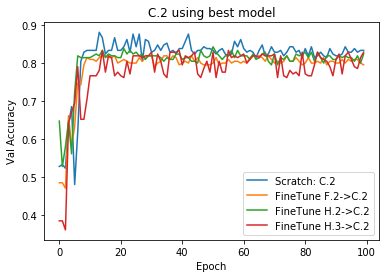

Sol C: F.2 39 59.420162200927734 0.8579545617103577
FineTune C.2->F.2 18 27.016923666000366 0.8579545617103577
FineTune H.2->F.2 24 39.978699922561646 0.875
FineTune H.3->F.2 12 20.62814950942993 0.8806818127632141


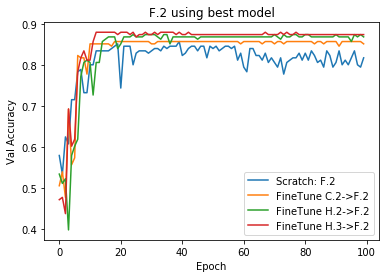

Sol C: H.2 68 159.73537969589233 0.870517909526825
FineTune C.2->H.2 75 187.22749972343445 0.8784860372543335
FineTune F.2->H.2 51 135.57344770431519 0.8685259222984314
FineTune H.3->H.2 17 47.76613402366638 0.8406374454498291


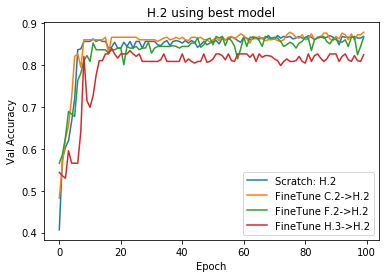

Sol C: H.3 30 84.02934336662292 0.872592568397522
FineTune C.2->H.3 77 206.37158370018005 0.8488888740539551
FineTune F.2->H.3 10 29.55898141860962 0.8533333539962769
FineTune H.2->H.3 95 296.32120728492737 0.8355555534362793


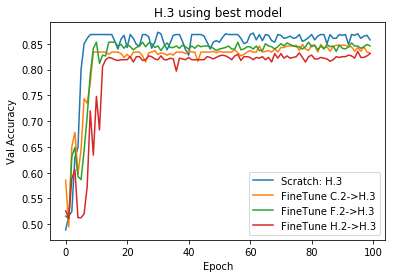

In [11]:
import matplotlib.pyplot as plt

for i in subject_codes:
    others = subject_codes.copy()
    others.remove(i)
    plt.plot(results[i]['test_acc_list'], label='Scratch: ' + i)
    max = np.max(results[i]['test_acc_list'])
    index = results[i]['test_acc_list'].index(max)
    print('Sol C: ' + i,index, results[i]['time_list'][index], max)
    for j in others:
        plt.plot(results2[j][i]['test_acc_list'], label="FineTune " + j + '->' + i)
        max = np.max(results2[j][i]['test_acc_list'])
        index = results2[j][i]['test_acc_list'].index(max)
        print("FineTune " + j + '->' + i,index, results2[j][i]['time_list'][index], max)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy')
    plt.title(i + ' using best model')
    plt.show()